## Project setup

Before we get started with any project, it is a good idea to create a [virtual environment](https://www.tensorflow.org/install/pip#2.-create-a-virtual-environment-recommended) to isolate project-specific libraries from the global environment. Python virtual environment stores dependencies required by different projects in separate places by creating virtual environments for them. It solves the “Project X depends on TensorFlow version 1.x but Project Y needs 2.x version” dilemma and keeps your global site-packages directory clean and manageable. Create a new virtual environment by running the following commands:

```bash
virtualenv -p python3.7 .env        # create a virtual environment (python3.7)
source .env/bin/activate            # activate the virtual environment
pip3 install -r requirements.txt    # install dependencies
deactivate                          # exit the virtual environment once you are done with the project

```

requirements.txt can be found [here](https://github.com/adelekuzmiakova/food-security-detecting-disease/blob/master/requirements.txt).

## Image classification

Image classification is the core task in computer vision. The goal of an image classification task is to read an image and **assign one label from a fixed set of categories to it**. Despite its simplicity, image classification has many applications in machine learning, web development, or data science. Additionally, many other computer vision problems, such as object detection or semantic segmentation, can be reduced to image classification.

This tutorial shows how to classify images of bean plants into 3 categories:

1. **Healthy**
2. **Angular Leaf Spot disease**
3. **Bean Rust disease**

![Alt text](assets/3classes.png?raw=true "3 Classes")


In this tutorial we will follow a standard machine learning workflow:

1. Examine the data and build an input pipeline 
2. Build the classification model
3. Train the model
4. Test the model, evaluate its performance, and fine-tune hyperparameters


We start with importing necessary libraries:

In [83]:
from __future__ import absolute_import, division, print_function, unicode_literals
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
#tfds.disable_progress_bar()
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

### Step 1: Examine the data and build an input pipeline

`TFDS` module provides a collection of ready-to-use datasets. In this example, we will be working with `beans` [dataset](https://github.com/AI-Lab-Makerere/ibean), where each image contains bean plants grown on small farms in East Africa. Beans are a staple in many East African cousines and represent a significant source of protein for school-aged children. 
Our goal is to help diagnose the health condition of bean crops and **develop a classifier that can predict whether the bean leaves have been affected by a disease or not**. Every image in this dataset is 500-by-500 pixels large and was taken by a smartphone camera on the farm. Also, every image is associated with exactly one condition (healthy, angular leaf spot disease, or bean rust disease). The training, validation, and test sets contain 1034, 133 and 128 images, respectively. 

Also, you can see a list of all datasets registered on TensorFlow [here](https://www.tensorflow.org/datasets/catalog/overview) or by using `tfds.list_builders()` method

In [2]:
# Enable eager execution
tf.enable_v2_behavior()

# Check out all available datasets 
#tfds.list_builders()

We load the data with the following arguments:

1. `name`: name of the dataset, can be obtained from `tfds.list_builders()`
2. `split`: indicates which split of the data to load
3. `as_supervised`: if `True`, then it returns a tuple `(img, label)` instead of a dictionary `{'image': img, 'label': label}`
4. `with_info`: if `True`, it will return a tuple containing the information associated with the dataset builder

In [108]:
(ds_train, ds_validation, ds_test), ds_info = tfds.load(
    name = 'beans', 
    split = ['train', 'validation', 'test'],
    as_supervised = True,
    with_info = True)
#print(ds_info)

We can build the training pipeline using the following transformations:
1. `ds_train.map`: applies normalization because TFDS returns images in unit8 format while the model requires float32 format
2. `ds_train.cache`: caches before shuffling 
3. `ds_train.shuffle`: shuffles the training example to ensure randomness and prevent potential class imbalance
4. `ds_train.batch`: splits the examples into batches
5. `ds_train.prefetch`: overlaps the preprocessing and model execution work

In [109]:
def normalize_image(image, label):
    """Normalizes images: `unit8` -> `float32`."""
    return tf.cast(image, tf.float32)/255., label

batch_size = 32

ds_train = ds_train.map(
    normalize_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(batch_size)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

Similarly, we can build the validation and test pipeline using similar transformations as above. The main difference is that now all the batches can be the same during each epoch so we don't shuffle the examples. Also, cahing is now done after batching.

In [110]:
ds_validation = ds_validation.map(
    normalize_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
ds_validation = ds_validation.batch(batch_size)
ds_validation = ds_validation.cache()
ds_validation = ds_validation.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = ds_test.map(
    normalize_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(batch_size)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

Now that we have a input pipeline ready, we can examine the data more closely. Specifically, it is a good idea to check for **class imbalance** and see whether there is a group of labels (*healthy*, *angular leaf spot disease*, or *bean rust disease*) that contains significantly fewer samples than other groups. If yes, that might be a problem for the deep learning model. But let's confirm that first:

In [ ]:
def return_class_labels(ds):
    """"Returns a list of class labels from a `DatasetV1Adapter` object."""
    l_labels = []
    for _, labels in ds.take(-1):
        labels = labels.numpy()
        l_labels.append(labels[:])
    return [item for sublist in l_labels for item in sublist]

In [96]:
training_labels = return_class_labels(ds_train)
print("The distribution of training labels is: ", (Counter(training_labels)))

validation_labels = return_class_labels(ds_validation)
print("The distribution of validation labels is: ", (Counter(validation_labels)))
      
test_labels = return_class_labels(ds_test)
print("The distribution of test labels is: ", (Counter(test_labels)))

The distribution of training labels is:  Counter({1: 348, 0: 345, 2: 341})
The distribution of validation labels is:  Counter({1: 45, 2: 44, 0: 44})
The distribution of test labels is:  Counter({0: 43, 1: 43, 2: 42})


Great, we see that all classes are evenly represented in train, validation, and test set. Now let's plot some of the images to see what they look like:

In [120]:
example = ds_train.take(1)
for sample in example:
    image, label = sample[0], sample[1]
    image = image.numpy()
    label = label.numpy()

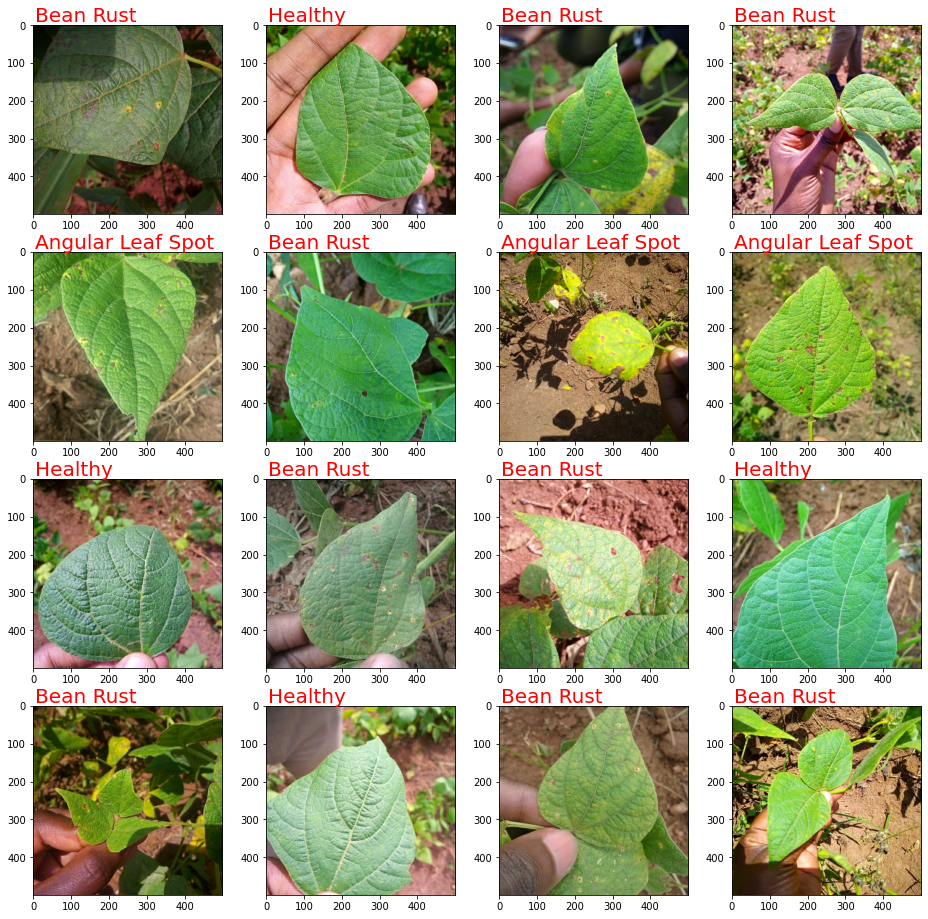

In [124]:
n_cols, n_rows = 4, 4
plt.rcParams['figure.figsize'] = [n_cols*4, n_rows*4]

fig = plt.figure()
for i in range(1, n_cols*n_rows + 1):
    ax = fig.add_subplot(n_rows, n_cols,i)
    ax.text(5, -9, "Angular Leaf Spot" if label[i] == 0 else "Bean Rust" if label[i] == 1 else "Healthy",
            color = 'red', fontsize = 20)
    ax.imshow(image[i, :, :, :], cmap = plt.get_cmap("jet"))

### Step 2: Build the classification model



In [95]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(500, 500, 3)),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'],
)

history = model.fit(
    ds_train,
    epochs=20,
    validation_data=ds_test,
)


Epoch 1/20
33/33 [==============================] - 18s 541ms/step - loss: 168.4775 - accuracy: 0.4004 - val_loss: 34.1816 - val_accuracy: 0.6094
Epoch 2/20
33/33 [==============================] - 14s 416ms/step - loss: 57.8217 - accuracy: 0.5077 - val_loss: 31.0965 - val_accuracy: 0.6250
Epoch 3/20
33/33 [==============================] - 14s 414ms/step - loss: 26.1234 - accuracy: 0.6393 - val_loss: 68.9032 - val_accuracy: 0.3516
Epoch 4/20
33/33 [==============================] - 14s 431ms/step - loss: 15.5850 - accuracy: 0.6828 - val_loss: 11.7798 - val_accuracy: 0.6953
Epoch 5/20
33/33 [==============================] - 14s 426ms/step - loss: 44.2994 - accuracy: 0.5928 - val_loss: 25.3020 - val_accuracy: 0.5938
Epoch 6/20
33/33 [==============================] - 14s 435ms/step - loss: 34.1535 - accuracy: 0.6354 - val_loss: 31.2516 - val_accuracy: 0.5078
Epoch 7/20
33/33 [==============================] - 14s 415ms/step - loss: 35.4822 - accuracy: 0.6209 - val_loss: 58.0846 - val_a

KeyboardInterrupt: 

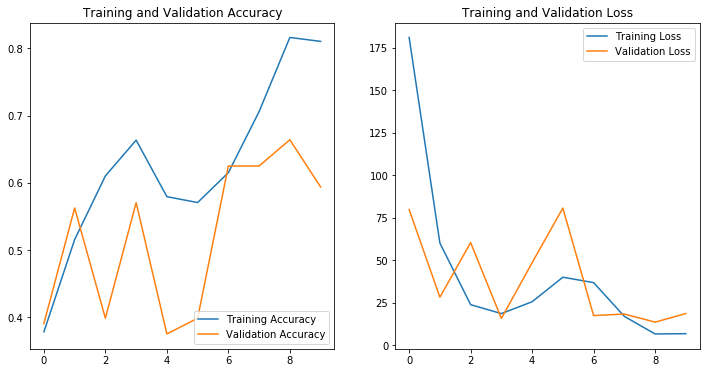

In [94]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [103]:
test_loss, test_acc = model.evaluate(ds_test)

print('\nTest accuracy:', test_acc)


      2/Unknown - 0s 68ms/step - loss: 10.0193 - accuracy: 0.8711
Test accuracy: 0.87109375


In [104]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [105]:
predictions = probability_model.predict(ds_test)


In [106]:
predictions[1]

array([0.23196931, 0.08533674, 0.08533674, 0.08533674, 0.08533674,
       0.08533674, 0.08533674, 0.08533674, 0.08533674, 0.08533674],
      dtype=float32)

In [107]:
np.argmax(predictions[1])


0

In [108]:
ds_test[0]


TypeError: 'DatasetV1Adapter' object does not support indexing